<a href="https://colab.research.google.com/github/bilalProgTech/btech-nmims/blob/master/NN-DL/Lab-Work/20231022-Lab-10-BTech-NNDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# System Libraries
import os
import random

# Data Handling Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# Libraries for Computer Vision and Deep Learning Models
import cv2
import tensorflow as tf
from keras.layers import Conv2D, BatchNormalization, Activation
from keras.layers import Input, InputLayer, MaxPooling2D
from keras.layers import Dropout, Conv2DTranspose, concatenate
from keras.metrics import MeanIoU
from keras import Model
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model

# ML Libraries
from sklearn.model_selection import train_test_split

# Breast Cancer Data Download & Processing

Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.

https://doi.org/10.1016/j.dib.2019.104863.

In [ ]:
%%time
!wget https://scholar.cu.edu.eg/Dataset_BUSI.zip
!unzip *.zip

In [3]:
!mkdir /content/Dataset_BUSI_with_GT/cancer_images

In [4]:
!cp /content/Dataset_BUSI_with_GT/benign/* /content/Dataset_BUSI_with_GT/cancer_images
!cp /content/Dataset_BUSI_with_GT/malignant/* /content/Dataset_BUSI_with_GT/cancer_images

In [5]:
image_path = '/content/Dataset_BUSI_with_GT/cancer_images/'
mask_2_list = []
images_list = []
for dirname, _, filenames in os.walk(image_path):
    for filename in filenames:
        if 'mask_' in filename:
            mask_2_list.append(dirname + filename)
        elif 'mask' not in filename:
            images_list.append(dirname + filename)

    Function to merge two mask images

There are few images with two cancer segments - thus merging will help to segment multiple cancer section in an image.

In [6]:
def merge_mask_images(mask_path_1, mask_path_2):
    # Load the actual and predicted masks as grayscale images
    mask_1 = cv2.imread(mask_path_1, cv2.IMREAD_GRAYSCALE)
    mask_2 = cv2.imread(mask_path_2, cv2.IMREAD_GRAYSCALE)

    # Merge the grayscale images into a single image
    merged_mask = np.zeros(mask_1.shape + (2,), dtype=np.uint8)
    merged_mask[:,:,0] = mask_1
    merged_mask[:,:,1] = mask_2
    merged_mask = np.max(merged_mask, axis=2)

    # Save the merged mask as a PNG image
    cv2.imwrite(mask_path_1, merged_mask)

### Masks Merging

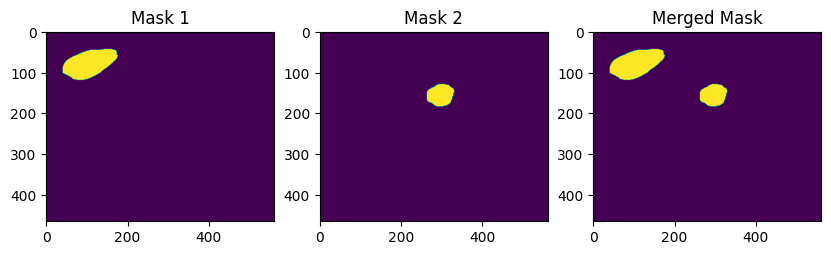

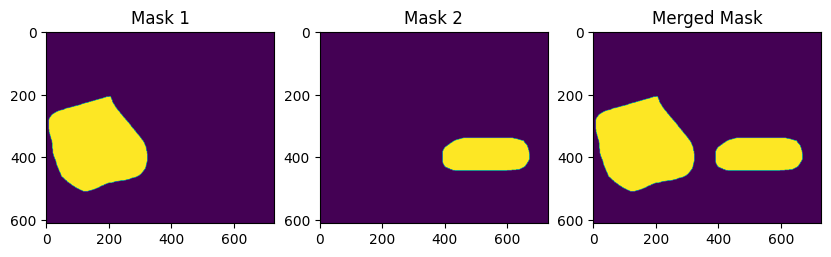

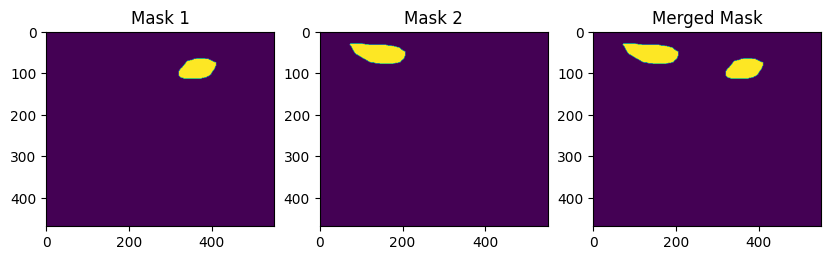

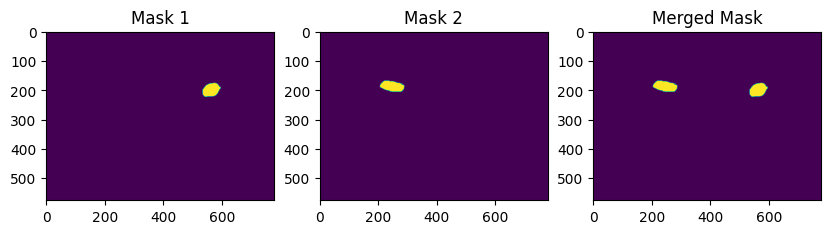

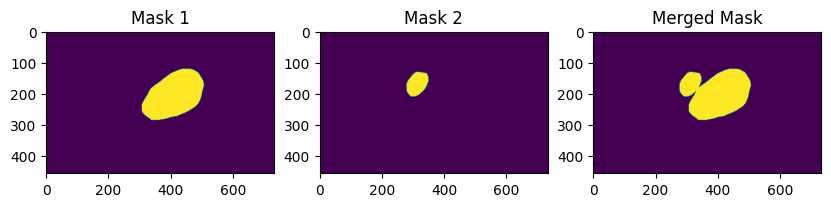

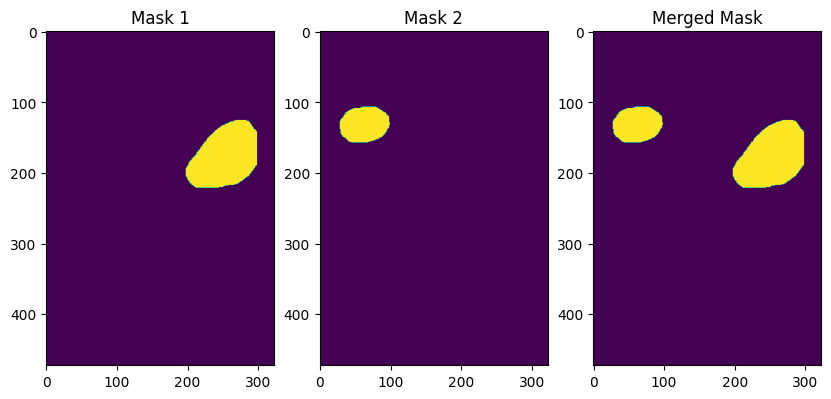

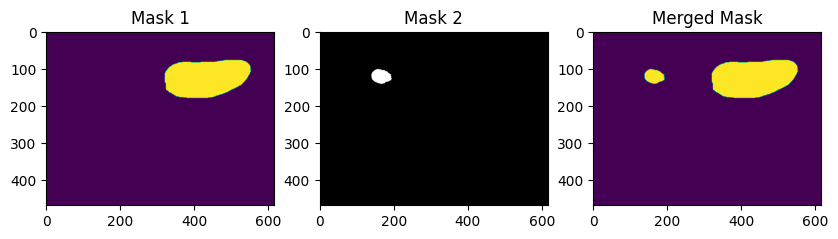

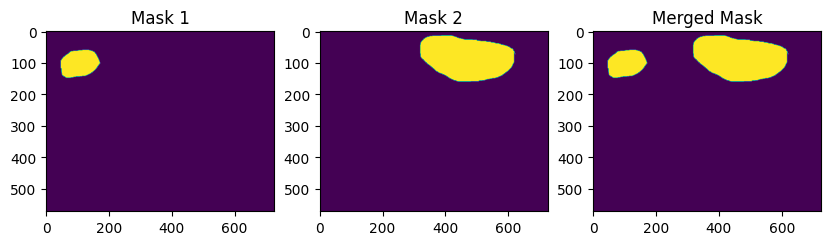

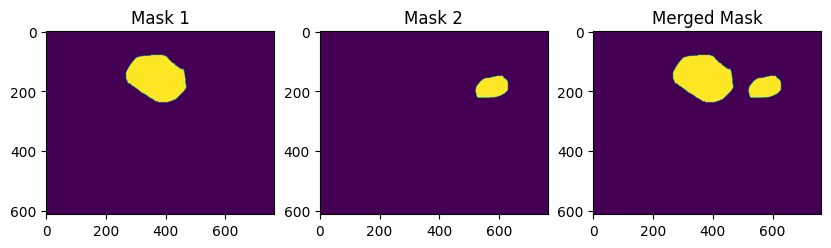

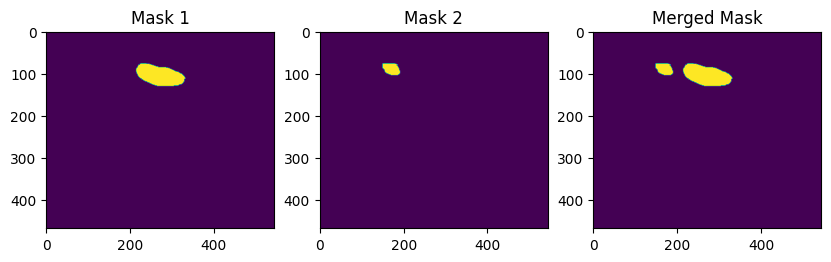

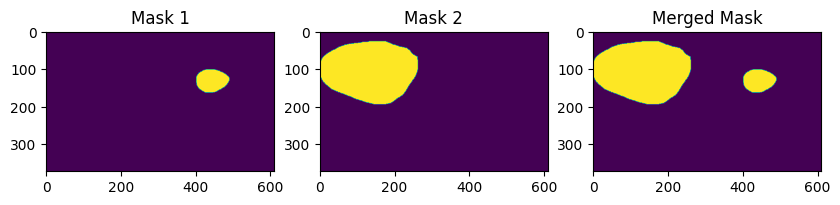

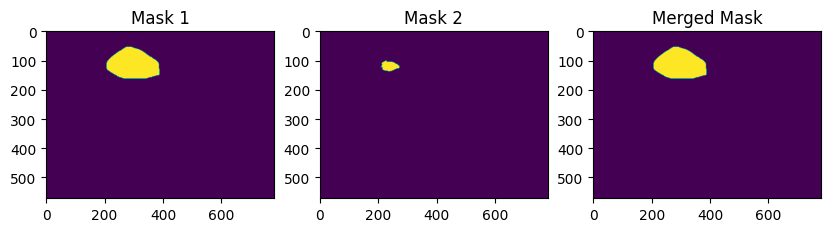

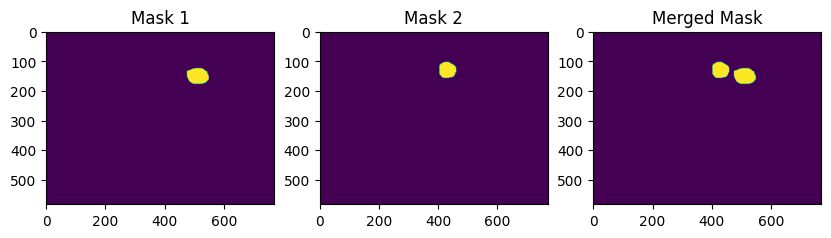

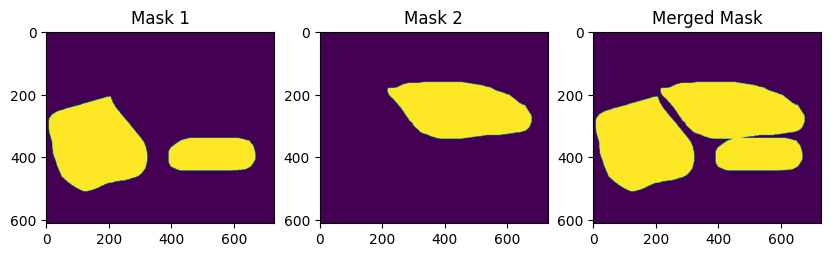

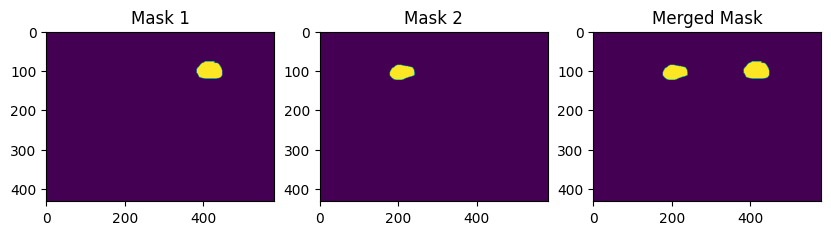

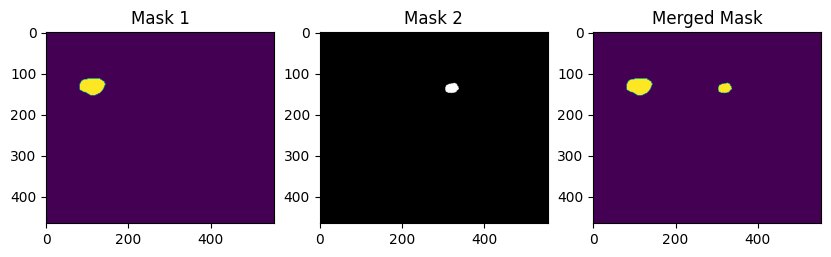

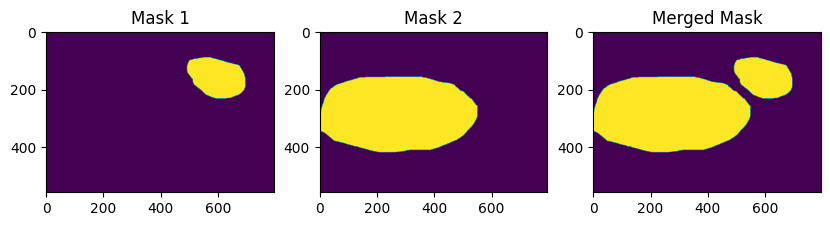

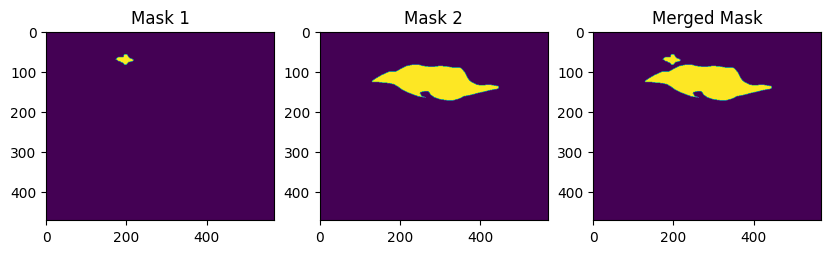

In [7]:
for mask_path_2 in mask_2_list:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    mask_path_1 = mask_path_2.split(')')[0] + ')_mask.png'
    image1 = plt.imread(mask_path_1)
    merge_mask_images(mask_path_1, mask_path_2)
    image2 = plt.imread(mask_path_2)
    image3 = plt.imread(mask_path_1)
    ax1.imshow(image1)
    ax1.set_title('Mask 1')
    ax2.imshow(image2)
    ax2.set_title('Mask 2')
    ax3.imshow(image3)
    ax3.set_title('Merged Mask')
    plt.show()

# Image and Data Pre-processing

## Dataframe for image and mask file path with type of tumors

In [8]:
images_df = pd.DataFrame({'image_path': images_list})
images_df['mask_path'] = images_df['image_path'].str.split(')').str[0]
images_df['mask_path'] = images_df['mask_path'] + ')_mask.png'
images_df['type'] = images_df['image_path'].str.split(' ').str[0].str.split('/').str[-1]
images_df.head()

,image_path,mask_path,type
0,/content/Dataset_BUSI_with_GT/cancer_images/be...,/content/Dataset_BUSI_with_GT/cancer_images/be...,benign
1,/content/Dataset_BUSI_with_GT/cancer_images/be...,/content/Dataset_BUSI_with_GT/cancer_images/be...,benign
2,/content/Dataset_BUSI_with_GT/cancer_images/be...,/content/Dataset_BUSI_with_GT/cancer_images/be...,benign
3,/content/Dataset_BUSI_with_GT/cancer_images/ma...,/content/Dataset_BUSI_with_GT/cancer_images/ma...,malignant
4,/content/Dataset_BUSI_with_GT/cancer_images/be...,/content/Dataset_BUSI_with_GT/cancer_images/be...,benign


### Distribution of Cancer type

In [9]:
images_df['type'].value_counts()

benign       437
malignant    210
Name: type, dtype: int64

### Flag for two mask images

In [10]:
two_mask_idx = images_df[images_df['image_path'].isin([i.split(')')[0] + ').png' for i in mask_2_list])].index
images_df['is_two_mask'] = 0
images_df.loc[two_mask_idx, 'is_two_mask'] = 1
images_df['is_two_mask'].value_counts()

0    630
1     17
Name: is_two_mask, dtype: int64

## Spliting into train and test list

In [11]:
train_list, test_list = train_test_split(images_df, test_size=0.1,
                                         random_state=1997, shuffle=True)
train_list = train_list.reset_index(drop=True)
test_list = test_list.reset_index(drop=True)

train_list.shape, test_list.shape

((582, 4), (65, 4))

### Distribution of two mask images in train and test set

*Note - Make sure you have multiple mask images in test set*

In [12]:
train_list['is_two_mask'].value_counts()

0    569
1     13
Name: is_two_mask, dtype: int64

In [13]:
test_list['is_two_mask'].value_counts()

0    61
1     4
Name: is_two_mask, dtype: int64

## Read and Resize the images and mask

### Function to read the images

In [14]:
def get_model_data(images_path_df, shape=256):
    data = {'img' : [], 'mask' : []}
    for i in range(len(images_path_df)):
        img = plt.imread(images_path_df.iloc[i]['image_path'])
        mask = plt.imread(images_path_df.iloc[i]['mask_path'])
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        data['img'].append(img)
        data['mask'].append(mask)
    return data

### Applying above function on train and test list of image paths

In [15]:
%%time
train_data = get_model_data(train_list)
test_data = get_model_data(test_list)

CPU times: user 5.74 s, sys: 623 ms, total: 6.36 s
Wall time: 5.9 s


## Sample Visualization

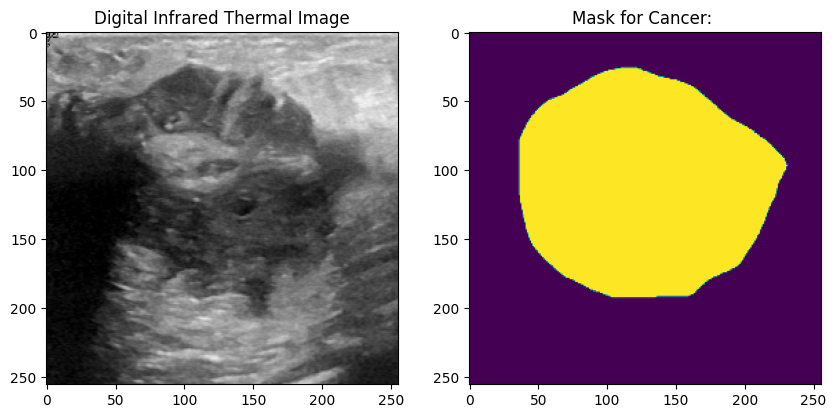

In [16]:
plt.figure(figsize = (10, 7))
plt.subplot(1, 2, 1)
plt.imshow(train_data['img'][100])
plt.title('Digital Infrared Thermal Image')
plt.subplot(1, 2, 2)
plt.imshow(train_data['mask'][100])
plt.title('Mask for Cancer: ')
plt.show()

# Segmentation Model

## Defining U-NET Model

* Define a custom convolution layers with ReLU activation, batch normalization, and same padding
* Define UNET Model Architecture with Encoder and Decoder

The U-Net is a convolutional neural network architecture designed for image segmentation tasks, specifically for biomedical image segmentation. The architecture of the U-Net consists of an encoder and decoder network with skip connections between corresponding layers.

The encoder network of the U-Net performs feature extraction from the input image, similar to other convolutional neural networks. The difference in the U-Net is the use of max pooling layers to downsample the feature maps, which reduces the spatial dimensions and increases the receptive field of the network.

The decoder network of the U-Net performs upsampling of the feature maps to generate the final segmentation map. This is done using transposed convolution layers, which perform the reverse operation of a regular convolution by increasing the spatial dimensions of the feature maps. Skip connections are then used to concatenate the feature maps from the corresponding layer in the encoder network to the upsampled feature maps in the decoder network. This helps to preserve the spatial information lost during the downsampling process.

The U-Net also uses custom convolutional blocks in both the encoder and decoder networks, which consist of two convolutional layers followed by batch normalization and ReLU activation. This helps to improve the performance of the network by reducing the vanishing gradient problem and accelerating the training process.

Finally, the output of the U-Net is a single-channel segmentation map, where each pixel value represents the probability of that pixel belonging to the foreground or background class. The sigmoid activation function is used in the final layer to ensure that the output values are between 0 and 1.

**Physics-based Impact**

In terms of using UNet as a physics-based model, it is possible to train a UNet to segment images based on physical properties of the objects in the image. For example, if the image contains particles or objects with a certain shape or size, a UNet can be trained to identify and segment these objects based on their physical characteristics.

The **He normal initializer** initializes the weights randomly using a Gaussian distribution with a mean of 0 and a standard deviation of sqrt(2 / fan_in), where fan_in is the number of input units in the weight tensor. The fan_in term in the denominator is used to scale the standard deviation of the Gaussian distribution based on the number of input units to the weight tensor, so that the variance of the output from each neuron is approximately the same as the variance of the input.

The idea behind the He normal initializer is that the variance of the output from each neuron should be approximately the same as the variance of the input. If the variance is too high, the output from the neuron can become too large and lead to saturation or vanishing gradients, which can hinder the training of the network. By using the He normal initializer, the weights are initialized in such a way that the variance of the output is roughly equal to the variance of the input, which can help improve the performance of the network during training.

In [17]:
# Function with 2 convolution layers
def CustomConv2d(image_input, filters, kernel_size=3):
    # Apply a convolution layer with specified number of filters and kernel size to the input image
    x = Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(image_input)

    # Apply batch normalization to the output of the convolution layer
    x = BatchNormalization()(x)

    # Apply ReLU activation function to the output of the batch normalization layer
    x = Activation(tf.nn.relu)(x)

    # Apply another convolution layer with specified number of filters and kernel size to the output of previous layer
    x = Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(tf.nn.relu)(x)

    # Return the output of this block
    return x

# U-Net Architectur - Encoder and Decoder
def UNET_Model(image_input, filters = 16, dropout = 0.1):

    # Encoder

    # Apply a convolution block with specified number of filters to the input image
    c1 = CustomConv2d(image_input, filters * 1)
    # Apply max pooling layer to the output of the previous convolution block
    p1 = MaxPooling2D((2,2))(c1)
    # Apply dropout regularization to the output of the max pooling layer
    p1 = Dropout(dropout)(p1)

    # Apply another convolution block to the output of the previous dropout layer
    c2 = CustomConv2d(p1, filters * 2)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = CustomConv2d(p2, filters * 4)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = CustomConv2d(p3, filters * 8)
    p4 = MaxPooling2D((2,2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = CustomConv2d(p4, filters * 16)

    # Decoder

    # Apply transposed convolution layer with specified number of filters and kernel size to the output of the last convolution block
    u6 = Conv2DTranspose(filters*8, (3, 3), strides = (2, 2),
                         padding = 'same')(c5)
    # Concatenate the output of the transposed convolution layer with the output of the second last convolution block
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = CustomConv2d(u6, filters * 8)

    u7 = Conv2DTranspose(filters*4, (3, 3), strides = (2, 2),
                         padding = 'same')(c6)

    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = CustomConv2d(u7, filters * 4)

    u8 = Conv2DTranspose(filters*2, (3, 3), strides = (2, 2),
                         padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = CustomConv2d(u8, filters * 2)

    u9 = Conv2DTranspose(filters*1, (3, 3), strides = (2, 2),
                         padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = CustomConv2d(u9, filters * 1)

    # Output Mask Segmentation with convolution layer with 1 filter of size (1,1) and applies sigmoid activation to the output
    output = Conv2D(1, (1, 1), activation = tf.nn.sigmoid)(c9)

    # This line creates the final model by defining the input and output layers
    # The input layer is image_input and the output layer is the output layer we defined above
    model = Model(inputs = [image_input], outputs = [output])

    # Return the model
    return model

## Initializing Input and U-Net Model

Mean Intersection over Union (MeanIoU) is a commonly used evaluation metric for image segmentation models. It measures the similarity between the predicted segmentation mask and the ground truth mask by calculating the intersection over union (IoU) for each class and then taking the average of these values across all classes. The IoU is defined as the ratio between the intersection and the union of the predicted and ground truth masks. A higher MeanIoU score indicates a better segmentation performance.

In [18]:
tf.keras.backend.clear_session()
inputs = Input((256, 256, 3))

# Pass the input layer to the UNET_Model function to create the model
unet_transformer = UNET_Model(inputs, dropout= 0.07)

# Compile the UNET model with the Adam optimizer, binary cross-entropy loss, and mean intersection-over-union (IoU) metric
unet_transformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy',
                         metrics = ['accuracy', MeanIoU(num_classes=2)])

## Training the Segmentation Model

In [ ]:
%%time

history = unet_transformer.fit(np.array(train_data['img']),
                               np.array(train_data['mask']),
                               epochs = 50, validation_split=0.1)

## Visualize the Segmentation Model using Keras `plot_model` function

In [ ]:
plot_model(
    unet_transformer,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

## Analysing Loss, Accuracy and IoU of validation data

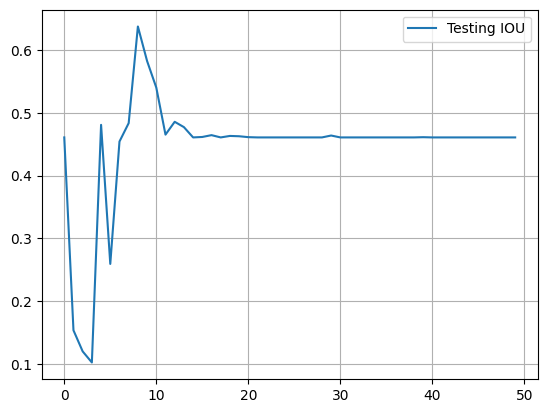

In [25]:
plt.plot(history.history['val_mean_io_u'], label = 'Testing IOU')
plt.legend()
plt.grid(True)

## Segmentation Model Evaluation

In [22]:
def iou(actual_mask, predicted_mask):
    # Compute the intersection of the two masks.
    intersection = np.logical_and(actual_mask, predicted_mask)
    # Compute the union of the two masks.
    union = np.logical_or(actual_mask, predicted_mask)
    # Calculate the IOU score by dividing the area of intersection by the area of union.
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [23]:
test_img = np.array(test_data['img'])
test_mask = np.array(test_data['mask'])
mask_pred = unet_transformer.predict(test_img)
print('IOU of Test Data: ' + str(iou(test_img, mask_pred)))

3/3 [==============================] - 1s 404ms/step
IOU of Test Data: 0.9984115209334936


In [31]:
test_list[test_list['is_two_mask']==1].index

Int64Index([14, 33, 49, 63], dtype='int64')

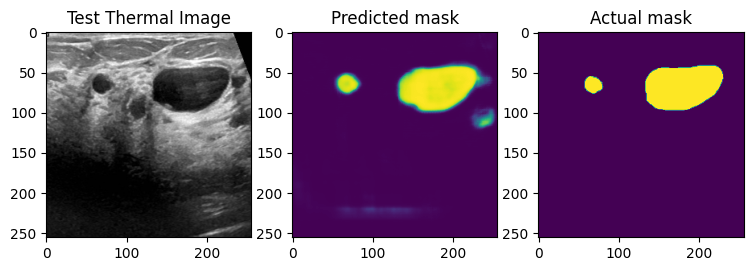

In [32]:
idx = test_list[test_list['is_two_mask']==1].index[0]

plt.figure(figsize=(9,9))

plt.subplot(1,3,1)
plt.imshow(test_img[idx])
plt.title('Test Thermal Image')

plt.subplot(1,3,2)
plt.imshow(mask_pred[idx])
plt.title('Predicted mask')

plt.subplot(1,3,3)
plt.imshow(test_mask[idx])
plt.title('Actual mask')
plt.show()